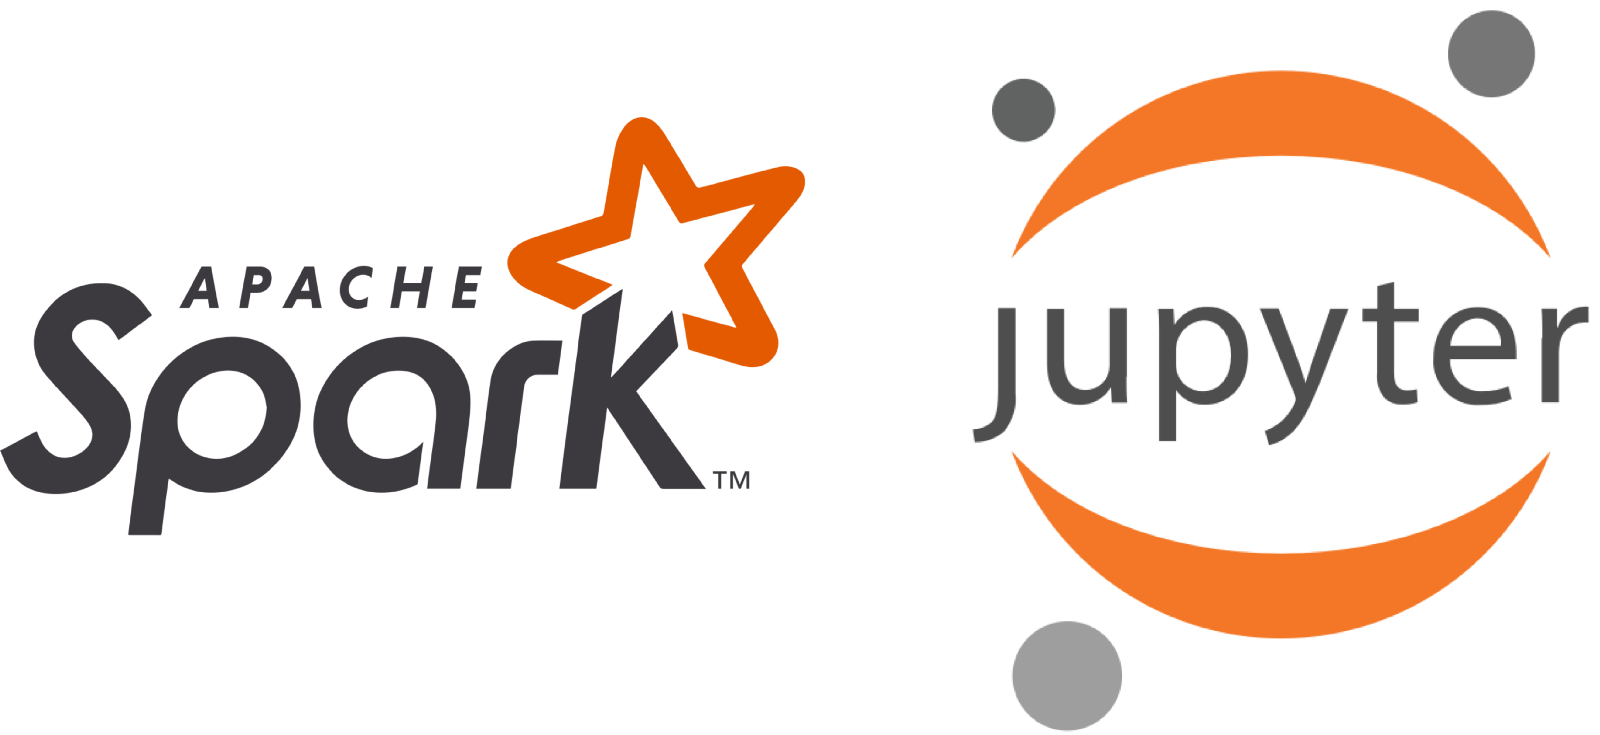

# How to find a needle in a very, very large haystack using Apache Spark

## Jupyter notebooks
First things first: this is a Jupyter notebook!

* Each box is a cell that can contain either Python code (or other languages), or Markdown.
* To execute a code cell, press Shift + Enter.

In [1]:
# Example: press Shift + Enter in this box.

print("This cell was executed.")

This cell was executed.


You can enter _command mode_ by pressing Escape, and enter _edit mode_ by pressing Return.

This next cell will make things a bit prettier for the rest of the workshop:

In [124]:
%run init.py

# Import PySpark packages
from pyspark.sql import *
import pyspark.sql.functions as F

# Use "col" as a shortcut for F.column
F.col = F.column

# Use "percentile_approx" as a shortcut for expr('percentile_approx()')
def percentile_approx(column, perc):
    return F.expr("percentile_approx({}, {})".format(column, perc))

F.percentile_approx = percentile_approx

# Set up some plotting parameters
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
sns.set_context("notebook", font_scale=2)


# Let's start using some Spark!

## Spotting fake reviews: Amazon Electronics

TODO: A real review 

## Some ideas

Maybe a fake reviewer could be identified by looking at some simple metrics...
* The reviewer posts way more reviews than the typical user
* Most of their reviews are positive
* Most of their reviews are sent very quickly
* Most of their reviews are low quality (other users don't find them very helpful)
* Most of their reviews texts and titles are shorter than the average
* A product that's being boosted by their merchant has been reviewed by a lot of fake reviewers

## The Data
In the folder you were sent, there are two data files in JSON format. You can check their names by invoking a shell command from Jupyter (just prepend `!` to the cell to run a shell command):

In [70]:
! ls -lh *.json

-rw-r--r-- 1 root root 1.4G Sep 22 19:46 reviews.json


We see there's a JSON file that's approximately 1.4 G. Not quite big data, but no slouch either :)


We can view the first few records using jq:

In [4]:
! head reviews.json | jq

{
  "asin": "B001I45T9O",
  "date": "2009-03-12 19:00:00",
  "fraction_helpful": 1,
  "overall": 5,
  "reviewText": "I did extensive web research before purchasing this laptop; while these seem a bit less common than their MSI and Asus brethren, the reviews were uniformly positive. The features that I was most interested in were long battery life, great keyboard, built-in bluetooth (I wanted to use my Microsoft wireless presenter mouse), and Windows 7 compatibility. After a few weeks of use, I am completely satisfied with the choice. It is a solid feeling little box, and the keyboard is better than most full-size laptops. The Windows 7 beta works great on it - battery life only a little less than with XP and performance at least as good as with XP. The display quality is excellent. I was initially concerned that the touch pad is rather small, but in practice that really doesn't seem to be a problem - I have no problem using it, although in general due to habit I prefer to use an extern

To load in a dataset, you use one of the `spark.read.{format}("path")` methods. 

In this case, the format is *JSON*, so we'll use `spark.read.json(path)`:

In [5]:
reviews = spark.read.json("reviews.json")
reviews.cache()

DataFrame[asin: string, date: string, fraction_helpful: double, overall: double, reviewText: string, reviewerID: string, reviewerName: string, summary: string, total_rating: bigint]

The `reviews` object is a Spark DataFrame. For this dataset, each row is a review.

You can view the contents of the first few rows by using the `display` function:

In [7]:
display(reviews)

,asin,date,fraction_helpful,overall,reviewText,reviewerID,reviewerName,summary,total_rating
0,B001I45T9O,2009-03-12 19:00:00,1.000000,5.0,I did extensive web research before purchasing this laptop; while these seem a bit less common t...,A2B82QHMXGBYFB,Amazon Customer,great all-round laptop,3
1,B001I45T9O,2009-02-01 18:00:00,0.857143,5.0,"After my laptop suddenly died recently, I needed a new portable computer, and fast. I did some ...",A1RTIPSBPL6L0D,Amazon Customer,The best Netbook out there right now!!,7
2,B001I45T9O,2008-12-13 18:00:00,1.000000,5.0,"I purchased the NC10 from amazon after doing quite a bit of research, I went to several stores ...",AK07I3266VXWY,"Amazon Customer ""Soutthpaw""","Hands Down, Best Netbook!",10
3,B001I45T9O,2009-04-16 19:00:00,0.900000,4.0,I purchased the white NC10 from Ritz Camera (an Amazon seller) about a week ago and received it ...,A2XL01EGU7MRGF,BE Babe,The first thing you should do when you receive this netbook -- run a screen test,10
4,B001I45T9O,2009-07-24 19:00:00,1.000000,4.0,"After carrying around a brick in my briefcase for years, I decided I needed to get a sub or netb...",A2M4NHKCBDV4OD,"B. V. Dam ""California Candyman""","Great Netbook, nice stlying, lightweight....small buts",2
5,B001I45T9O,2009-02-03 18:00:00,0.833333,5.0,Pros:1.) 6-8 hours battery life2.) 30 second boot up time3.) the best keyboard4.) LCD with backl...,A10BXAXOXN8H7A,Chad Herrella,The best netbook as of now!,6
6,B001I45T9O,2009-01-20 18:00:00,0.909091,4.0,This is an update to the previous review. After several days of loading new drivers and updates ...,A24957HBA987VN,"C. Moore ""The Authorguy""",Stuff you should know,11
7,B001I45T9O,2009-02-28 18:00:00,1.000000,5.0,After a few months of reading reviews about of all of the positives and negatives that come with...,AENBUGC3GZN78,"C. Rash ""Bandicoot""",Good things come in small packages,3
8,B001I45T9O,2008-11-21 18:00:00,0.976190,4.0,The Samsung NC10 is clearly the best netbook on the market right now. As a previous owner of the...,A1ALP9R0BD9XBB,"Daniel ""shinbo""",Bottom line best netbook out of them all.,42
9,B001I45T9O,2009-01-26 18:00:00,0.904762,5.0,"I was all set to get the Asus eeePC1000HA netbook until I heard about this new Samsung, spent a ...",AT6CZDCP4TRGA,Eduarrdo Nietzsche,"""Less"" really IS ""more!"" and all the buzz turned out to be TRUE, for once!",21


...and you can see the number of rows in the dataframe calling the `.count()` method:

In [8]:
print("There are ", reviews.count(), " reviews in this dataset.")

There are  1689188  reviews in this dataset.


The columns in this file are:

* `asin`: an Amazon product identifier
* `date`: the date of the review
* `overall`: the user's review
* `summary`: the title of the review
* `reviewText`: the text of the review
* `reviewerID`: the ID of the user
* `reviewerName`: the name of the reviewer
* `total_rating`: how many people rated the review
* `fraction_helpful`: the fraction of people who found the review helpful

## Diversion: the Spark Web UI
If you navigate to [http://localhost:4040](http://localhost:4040), you will see the Spark Web UI. The Web UI works like a "Task Manager" for Spark -- you can see currently ongoing jobs, how those jobs are broken up into tasks, and _kill_ current tasks.

<hr>

# Heuristics for identifying fake reviews
Based on this data, how could we spot a fake reviewer and a product that's been boosted by fake reviews?

## Aggregations: let's look at the distribution of reviews (1-5 stars)

In [9]:
# Take the reviews, group them by the number of star ("overall"), and
# count the number of reviews in each group.
#

reviews_by_stars = reviews \
    .groupBy("overall") \
    .agg(F.count("*").alias("count")) \
    .orderBy("overall")

display(reviews_by_stars)

,overall,count
0,1.0,108725
1,2.0,82139
2,3.0,142257
3,4.0,347041
4,5.0,1009026


### Let's dissect that call:

* We're calling several methods on the dataframe in a row. This is called a **pipeline**.
* I put each method call on a separate line to make it easier to see the flow.
* The `.groupBy()` method separates the data into groups
* The `.agg()` method computes an _aggregation_ on the groups, such that one value is returned for each group.
* The `F.` namespace contains a number of "SparkSQL" functions that can be used to do computations.

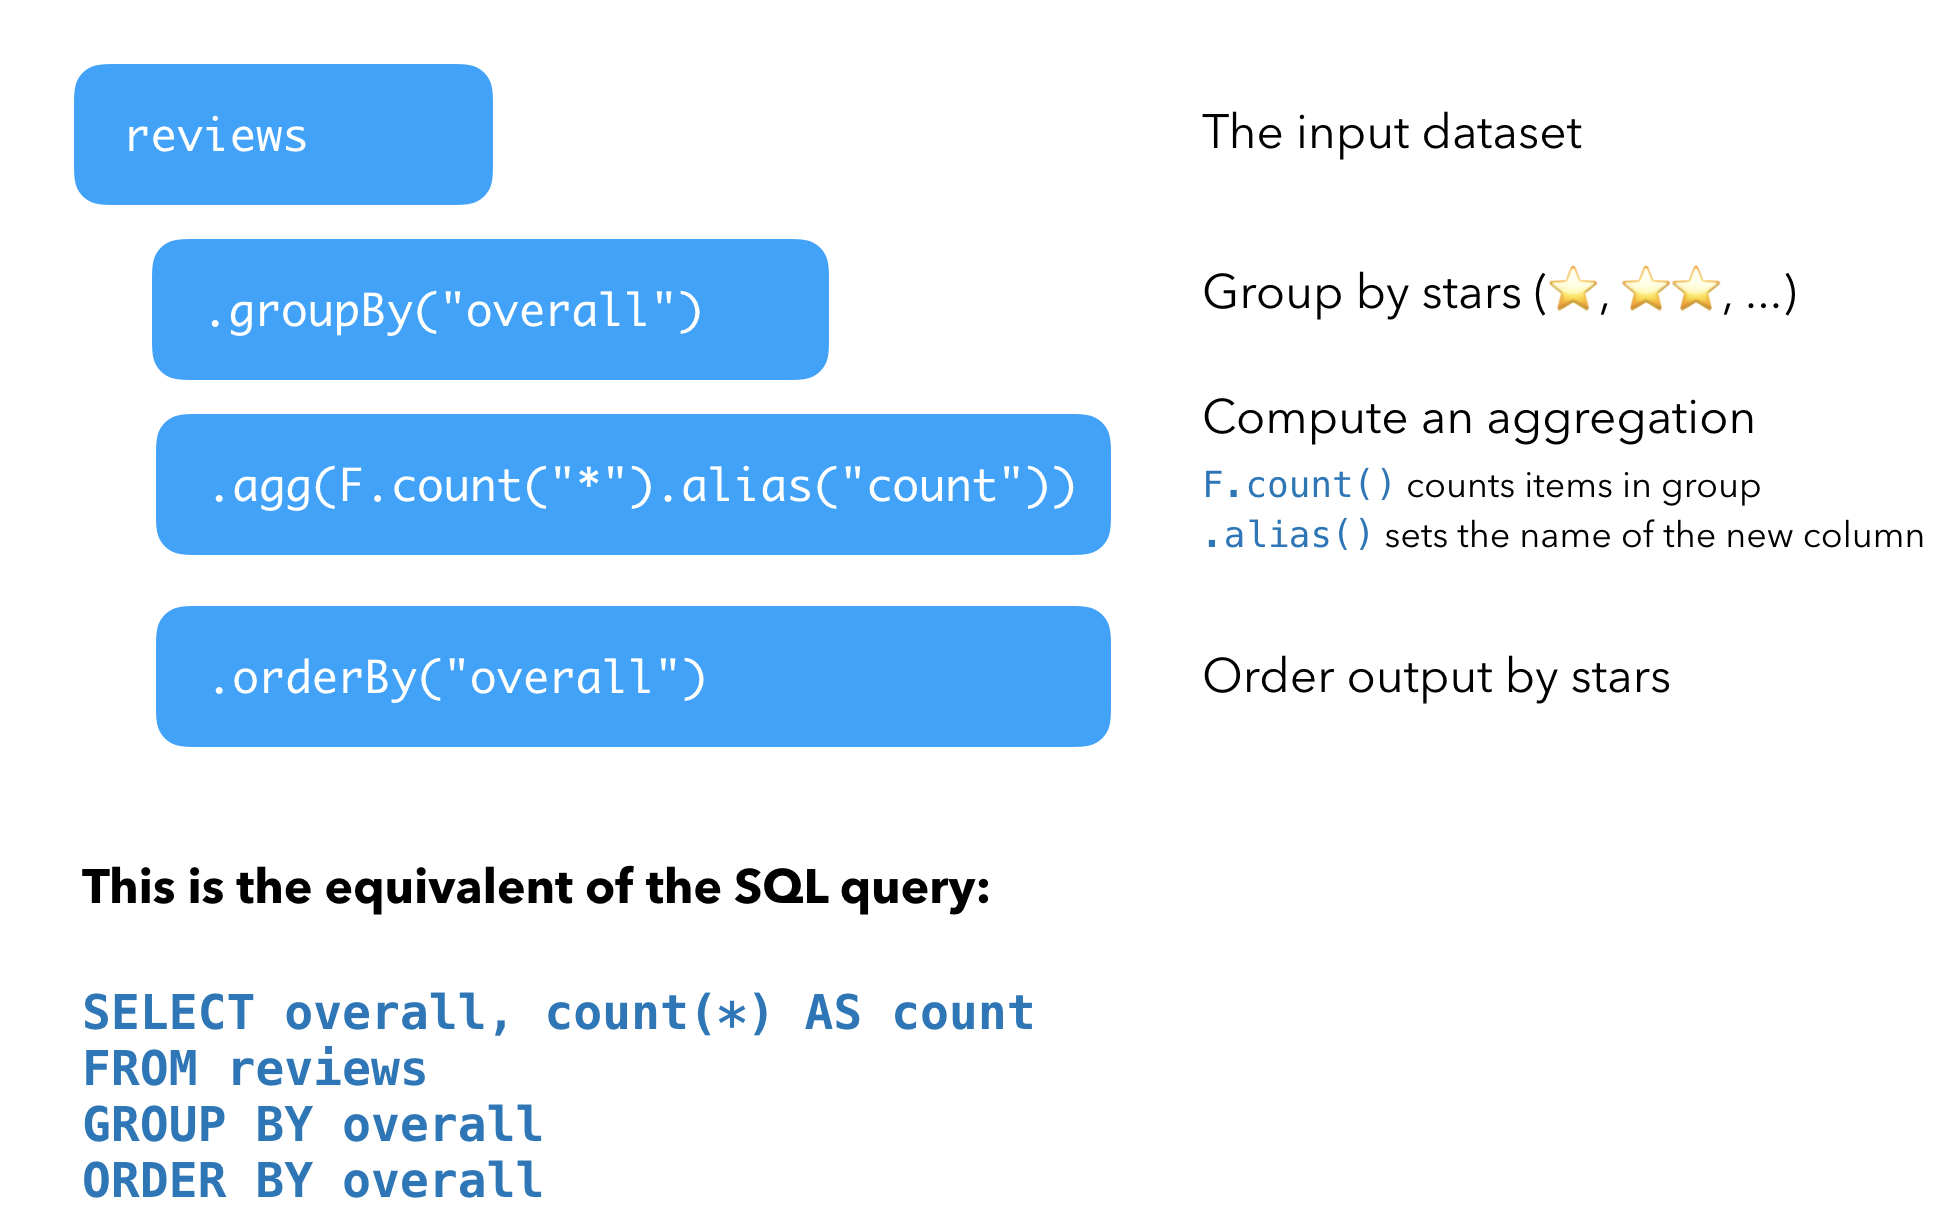

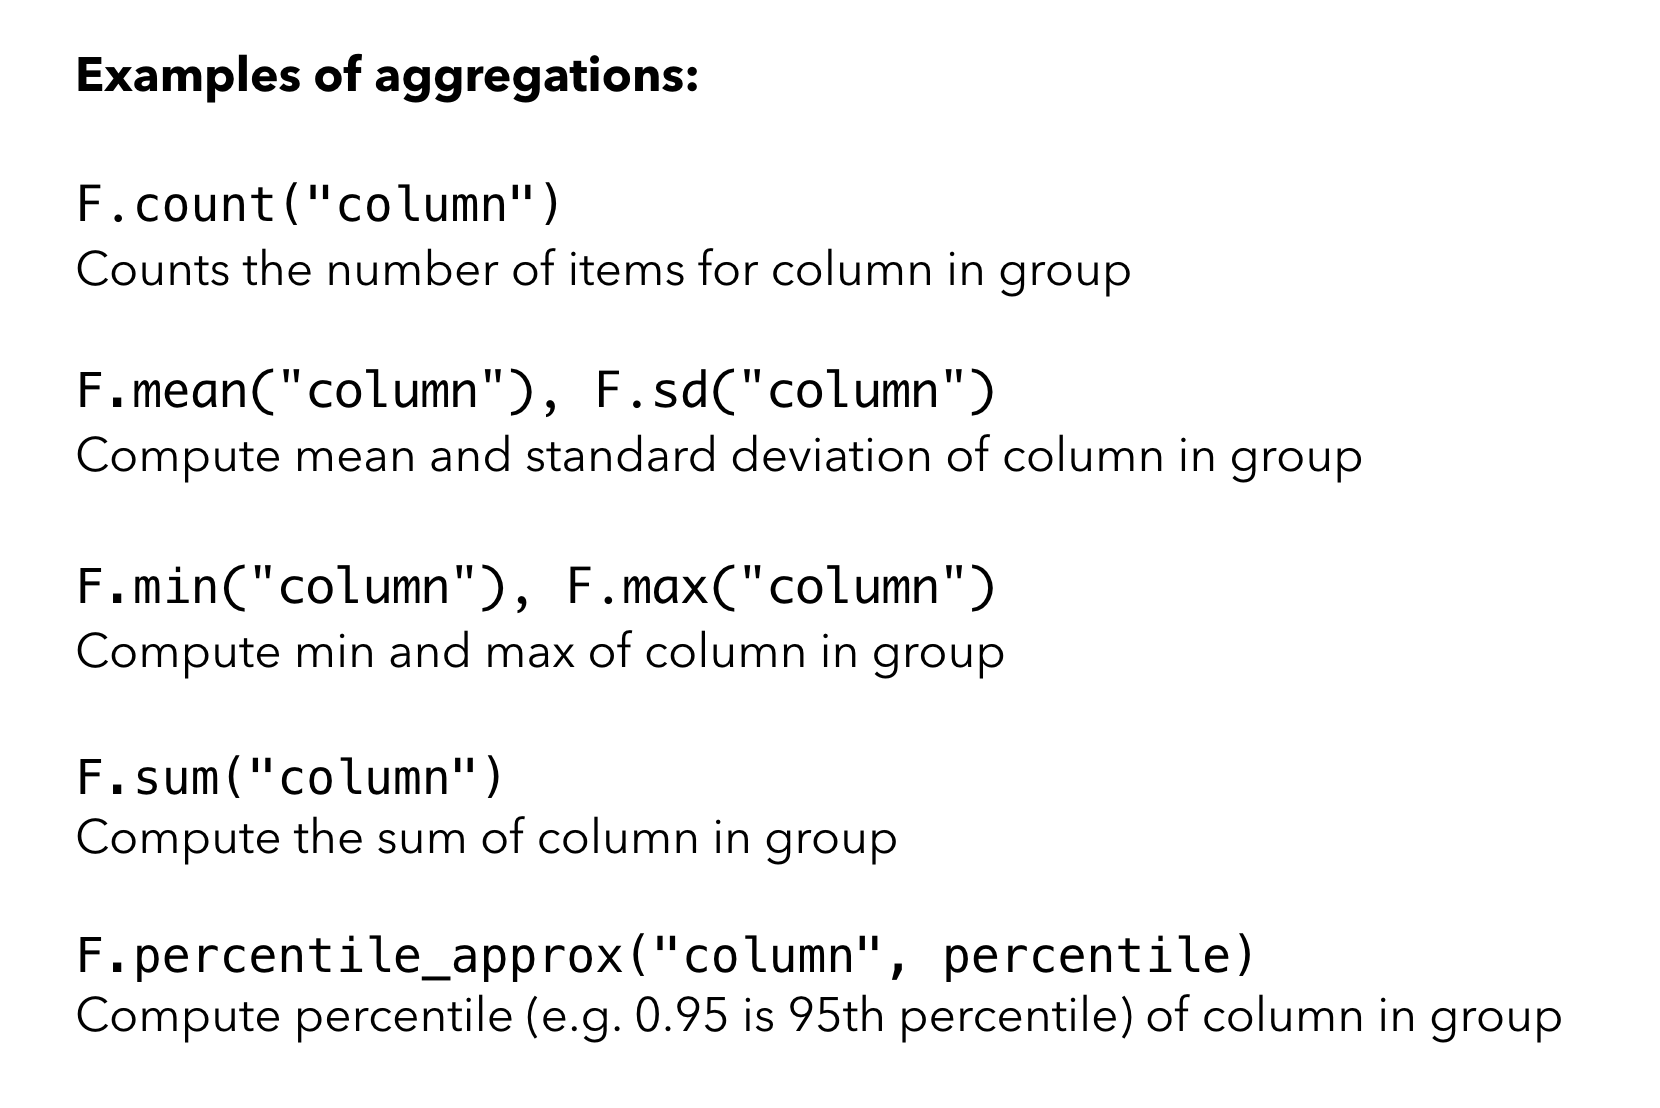

Let's visualize that distribution:

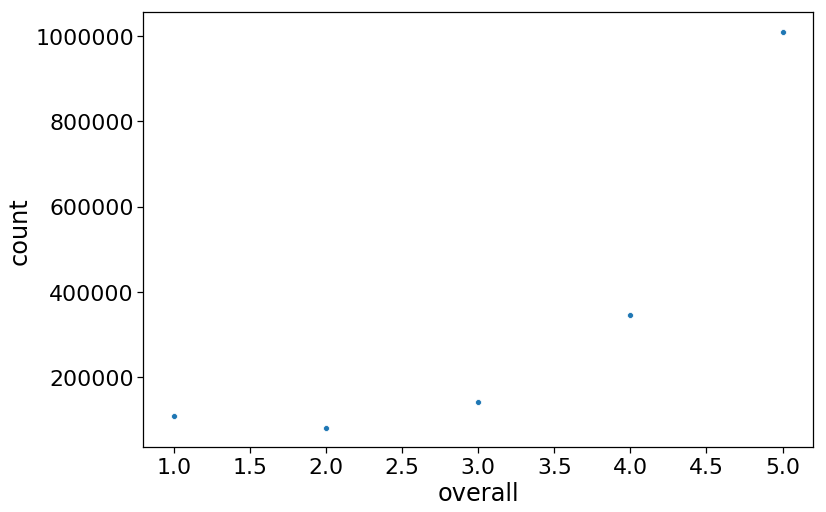

In [79]:
reviews_by_stars.plot(x="overall", y="count", kind="scatter")

## How many reviews do users leave, typically?

Intuition: some users might leave way more reviews than others and way more often, especially if they have a financial incentive to do so.

**Task: for each reviewer, compute total number of reviews and review rate (# reviews/day)**

In [27]:
# Group by reviewer ID and count reviews.
# Returns a table of number of reviews left by each user.

# Functions used:
# - groupBy -- to group the data (see above)
# - agg -- to specify an aggregation (see above)
# - count() -- to count items in group
# - datediff(date2, date1) -- computes difference in days between date2 and date1.
# - mean("overall") -- computes the average rating

count_reviews = reviews \
    .groupBy("reviewerID") \
    .agg(
        F.count("*").alias("count_reviews"),
        F.datediff(F.max("date"), F.min("date")).alias("activity_time_span"),
        F.mean("overall").alias("mean_overall"),
        F.mean("fraction_helpful").alias("mean_fraction_helpful")
    )

display(count_reviews)

,reviewerID,count_reviews,activity_time_span,mean_overall,mean_fraction_helpful
0,A06983862QXQ79V198HHI,5,369,4.400000,0.000000
1,A10123371OF8W0NAB6A1Q,10,48,3.900000,0.350000
2,A10C5589JX44C7,5,438,3.400000,0.200000
3,A10KHX41ONY4U1,5,377,5.000000,0.200000
4,A10M0GF5ZFODYU,32,1280,4.468750,0.317708
5,A10T7OCXQFU89X,7,751,3.571429,0.414286
6,A10T8DZNS4DMYL,5,9,4.000000,0.000000
7,A117LEKZFV4ZHC,8,1238,2.750000,0.096591
8,A11F5CJ7LAR24U,6,685,4.833333,0.333333
9,A11JEFCFYWYV4W,8,364,4.750000,0.250000


In [35]:
# I actually want the (number of reviews) / (activity time span) to get rate of posting reviews

# The withColumn(columnName, columnExpression) method adds a new column
count_reviews = count_reviews.withColumn("reviews_per_day", F.expr("count_reviews / (1+activity_time_span)"))

display(count_reviews)

,reviewerID,count_reviews,activity_time_span,mean_overall,mean_fraction_helpful,reviews_per_day
0,A06983862QXQ79V198HHI,5,369,4.400000,0.000000,0.013514
1,A10123371OF8W0NAB6A1Q,10,48,3.900000,0.350000,0.204082
2,A10C5589JX44C7,5,438,3.400000,0.200000,0.011390
3,A10KHX41ONY4U1,5,377,5.000000,0.200000,0.013228
4,A10M0GF5ZFODYU,32,1280,4.468750,0.317708,0.024980
5,A10T7OCXQFU89X,7,751,3.571429,0.414286,0.009309
6,A10T8DZNS4DMYL,5,9,4.000000,0.000000,0.500000
7,A117LEKZFV4ZHC,8,1238,2.750000,0.096591,0.006457
8,A11F5CJ7LAR24U,6,685,4.833333,0.333333,0.008746
9,A11JEFCFYWYV4W,8,364,4.750000,0.250000,0.021918


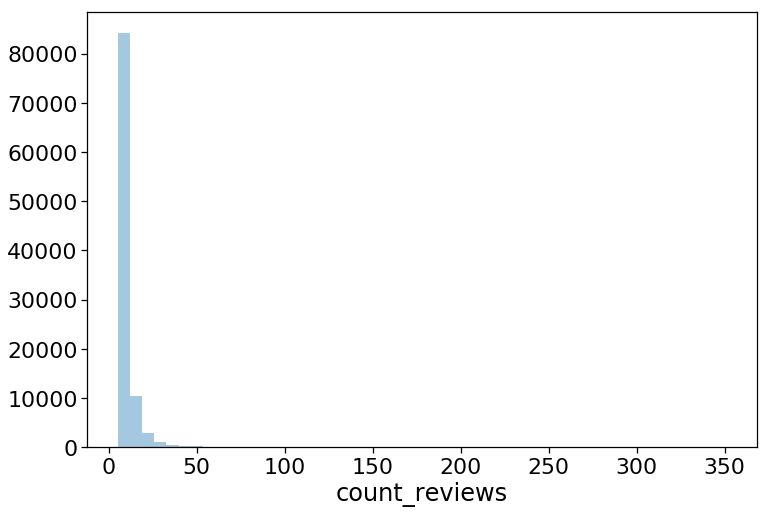

In [41]:
# Plot a histogram of the number of reviews

count_reviews.plot(x="count_reviews", kind="hist")

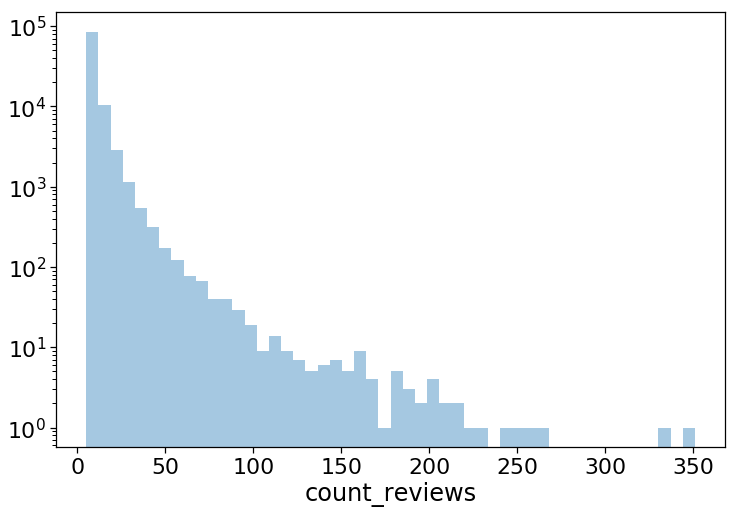

In [42]:
# Plot a histogram of the number of reviews, but use a logarithmic Y axis instead

count_reviews.plot(x="count_reviews", kind="hist", logy=True)

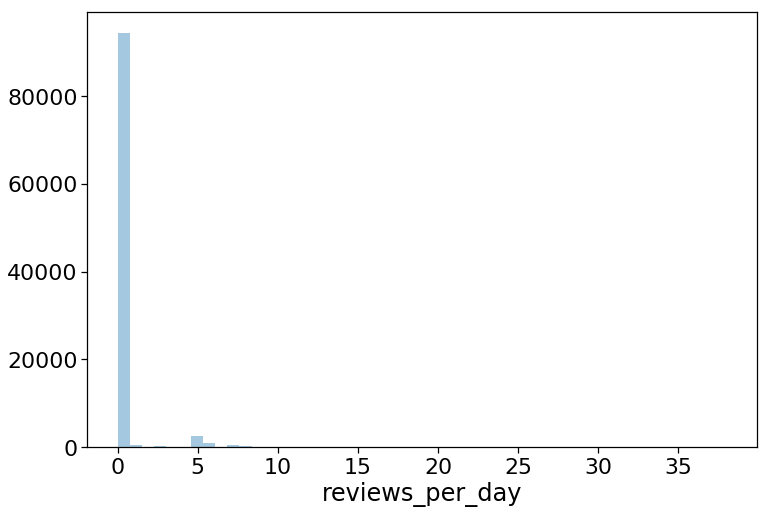

In [44]:
# Plot a histogram of the review posting rate

count_reviews.plot(x="reviews_per_day", kind="hist")

The *vast* majority of users leaves fewer than 50 reviews, and posts 1 or fewer reviews per day. 

**How do we quantify this more precisely?**

The function `percentile_approx` is an aggregation function that returns an approximate percentile. 

In [56]:
# Compute 50th (median), 90th, 95th, and 99th percentile (X percentile: X% of users left this many reviews or fewer).
# When you don't groupBy() first, agg() computes a summary on the whole dataset

perc_count_reviews = count_reviews.agg(
    F.percentile_approx("count_reviews", 0.5).alias("median"),
    F.percentile_approx("count_reviews", 0.9).alias("90"),
    F.percentile_approx("count_reviews", 0.95).alias("95"),
    F.percentile_approx("count_reviews", 0.99).alias("99")
)

display(perc_count_reviews)

,median,90,95,99
0,7,14,19,39


In [ ]:
# TODO: Compute 50th, 90th, 95th, and 99th percentile for posting rate of reviews (column "reviews_per_day") 

perc_rate_reviews = count_reviews.agg(...)

display(perc_rate_reviews)

Let's find what those reviewers look like! 

We take `count_reviews` (a table of user IDs and review counts) and join it with the `review` table, using `reviewerID` as the joining column.

In [47]:
reviews_with_counts = reviews.join(count_reviews, "reviewerID")

# Check it out! Now all the new columns we created are in the new table
display(reviews_with_counts)

,reviewerID,asin,date,fraction_helpful,overall,reviewText,reviewerName,summary,total_rating,count_reviews,activity_time_span,mean_overall,mean_fraction_helpful,reviews_per_day
0,A2B82QHMXGBYFB,B001I45T9O,2009-03-12 19:00:00,1.000000,5.0,I did extensive web research before purchasing this laptop; while these seem a bit less common t...,Amazon Customer,great all-round laptop,3,10,1948,4.400000,0.550000,0.005131
1,A1RTIPSBPL6L0D,B001I45T9O,2009-02-01 18:00:00,0.857143,5.0,"After my laptop suddenly died recently, I needed a new portable computer, and fast. I did some ...",Amazon Customer,The best Netbook out there right now!!,7,6,2466,4.000000,0.809524,0.002432
2,AK07I3266VXWY,B001I45T9O,2008-12-13 18:00:00,1.000000,5.0,"I purchased the NC10 from amazon after doing quite a bit of research, I went to several stores ...","Amazon Customer ""Soutthpaw""","Hands Down, Best Netbook!",10,8,1829,4.125000,0.557692,0.004372
3,A2XL01EGU7MRGF,B001I45T9O,2009-04-16 19:00:00,0.900000,4.0,I purchased the white NC10 from Ritz Camera (an Amazon seller) about a week ago and received it ...,BE Babe,The first thing you should do when you receive this netbook -- run a screen test,10,7,1040,4.571429,0.829870,0.006724
4,A2M4NHKCBDV4OD,B001I45T9O,2009-07-24 19:00:00,1.000000,4.0,"After carrying around a brick in my briefcase for years, I decided I needed to get a sub or netb...","B. V. Dam ""California Candyman""","Great Netbook, nice stlying, lightweight....small buts",2,9,4220,4.000000,0.546296,0.002132
5,A10BXAXOXN8H7A,B001I45T9O,2009-02-03 18:00:00,0.833333,5.0,Pros:1.) 6-8 hours battery life2.) 30 second boot up time3.) the best keyboard4.) LCD with backl...,Chad Herrella,The best netbook as of now!,6,5,1362,5.000000,0.916667,0.003668
6,A24957HBA987VN,B001I45T9O,2009-01-20 18:00:00,0.909091,4.0,This is an update to the previous review. After several days of loading new drivers and updates ...,"C. Moore ""The Authorguy""",Stuff you should know,11,21,3444,4.142857,0.491336,0.006096
7,AENBUGC3GZN78,B001I45T9O,2009-02-28 18:00:00,1.000000,5.0,After a few months of reading reviews about of all of the positives and negatives that come with...,"C. Rash ""Bandicoot""",Good things come in small packages,3,10,1350,4.900000,0.590000,0.007402
8,A1ALP9R0BD9XBB,B001I45T9O,2008-11-21 18:00:00,0.976190,4.0,The Samsung NC10 is clearly the best netbook on the market right now. As a previous owner of the...,"Daniel ""shinbo""",Bottom line best netbook out of them all.,42,7,1484,4.000000,0.400433,0.004714
9,AT6CZDCP4TRGA,B001I45T9O,2009-01-26 18:00:00,0.904762,5.0,"I was all set to get the Asus eeePC1000HA netbook until I heard about this new Samsung, spent a ...",Eduarrdo Nietzsche,"""Less"" really IS ""more!"" and all the buzz turned out to be TRUE, for once!",21,145,4233,3.737931,0.604219,0.034247


Let's look at that 5% tail of users with more than 19 reviews, and more than XXX reviews per day (TODO: you computed this two cells ago).

In [ ]:
# TODO: Fill XXX here
suspicious_reviews = reviews_with_counts \
    .filter("count_reviews > 19 and reviews_per_day > XXX") \
    .orderBy("reviewerID")
    
display(suspicious_reviews, n=30)

<br>
<div style="text-align:center; font-size: 5rem;">🧐 HMMM...</div>


<br>
"Ben" left 22 reviews in three days, all five stars, all with the same title. 

In [68]:
suspicious_reviews.count() / reviews.count()

0.0007417765222106716

Let's add a `is_fake_candidate` column to our reviews dataset. We can use `F.expr()` to return a boolean (True or False) column using the same condition as the `.filter()` call:

In [90]:
# TODO: Fill XXX here
reviews_with_counts = reviews_with_counts \
    .withColumn("is_fake_candidate", F.expr("count_reviews > 19 and reviews_per_day > 2.6"))

display(reviews_with_counts)

,reviewerID,asin,date,fraction_helpful,overall,reviewText,reviewerName,summary,total_rating,count_reviews,activity_time_span,mean_overall,mean_fraction_helpful,reviews_per_day,is_suspicious_candidate,is_fake_candidate
0,A2B82QHMXGBYFB,B001I45T9O,2009-03-12 19:00:00,1.000000,5.0,I did extensive web research before purchasing this laptop; while these seem a bit less common t...,Amazon Customer,great all-round laptop,3,10,1948,4.400000,0.550000,0.005131,False,False
1,A1RTIPSBPL6L0D,B001I45T9O,2009-02-01 18:00:00,0.857143,5.0,"After my laptop suddenly died recently, I needed a new portable computer, and fast. I did some ...",Amazon Customer,The best Netbook out there right now!!,7,6,2466,4.000000,0.809524,0.002432,False,False
2,AK07I3266VXWY,B001I45T9O,2008-12-13 18:00:00,1.000000,5.0,"I purchased the NC10 from amazon after doing quite a bit of research, I went to several stores ...","Amazon Customer ""Soutthpaw""","Hands Down, Best Netbook!",10,8,1829,4.125000,0.557692,0.004372,False,False
3,A2XL01EGU7MRGF,B001I45T9O,2009-04-16 19:00:00,0.900000,4.0,I purchased the white NC10 from Ritz Camera (an Amazon seller) about a week ago and received it ...,BE Babe,The first thing you should do when you receive this netbook -- run a screen test,10,7,1040,4.571429,0.829870,0.006724,False,False
4,A2M4NHKCBDV4OD,B001I45T9O,2009-07-24 19:00:00,1.000000,4.0,"After carrying around a brick in my briefcase for years, I decided I needed to get a sub or netb...","B. V. Dam ""California Candyman""","Great Netbook, nice stlying, lightweight....small buts",2,9,4220,4.000000,0.546296,0.002132,False,False
5,A10BXAXOXN8H7A,B001I45T9O,2009-02-03 18:00:00,0.833333,5.0,Pros:1.) 6-8 hours battery life2.) 30 second boot up time3.) the best keyboard4.) LCD with backl...,Chad Herrella,The best netbook as of now!,6,5,1362,5.000000,0.916667,0.003668,False,False
6,A24957HBA987VN,B001I45T9O,2009-01-20 18:00:00,0.909091,4.0,This is an update to the previous review. After several days of loading new drivers and updates ...,"C. Moore ""The Authorguy""",Stuff you should know,11,21,3444,4.142857,0.491336,0.006096,False,False
7,AENBUGC3GZN78,B001I45T9O,2009-02-28 18:00:00,1.000000,5.0,After a few months of reading reviews about of all of the positives and negatives that come with...,"C. Rash ""Bandicoot""",Good things come in small packages,3,10,1350,4.900000,0.590000,0.007402,False,False
8,A1ALP9R0BD9XBB,B001I45T9O,2008-11-21 18:00:00,0.976190,4.0,The Samsung NC10 is clearly the best netbook on the market right now. As a previous owner of the...,"Daniel ""shinbo""",Bottom line best netbook out of them all.,42,7,1484,4.000000,0.400433,0.004714,False,False
9,AT6CZDCP4TRGA,B001I45T9O,2009-01-26 18:00:00,0.904762,5.0,"I was all set to get the Asus eeePC1000HA netbook until I heard about this new Samsung, spent a ...",Eduarrdo Nietzsche,"""Less"" really IS ""more!"" and all the buzz turned out to be TRUE, for once!",21,145,4233,3.737931,0.604219,0.034247,False,False


# Are reviews in the "suspicious" set different from the general set?

## Example: helpfulness

In [93]:
display(reviews_with_counts.groupBy("is_fake_candidate").agg(
    F.mean("fraction_helpful")
))

,is_fake_candidate,avg(fraction_helpful)
0,True,0.111365
1,False,0.322028


The average helpfulness fraction is only ~11% for reviews in the "suspicious" set we identified, versus ~32% in the general population.

## TODO: Length of reviews

Remember how we suspected that the review length and title length might be, on average, shorter for fake reviews than real reviews?

Let's try to validate this hunch. 

You'll need:
- the name of the columns containing title and body of the review
- the function `F.length()`, which computes the number of characters in a column

The output should be a new DataFrame with columns `title_length` and `text_length`.

In [ ]:
# TODO: Create a new dataframe with two columns representing the lengths of title and body
reviews_with_lengths = reviews_with_counts \
    .withColumn(..., ...) \
    .withColumn(..., ...)

Next, let's look at the average `title_length` and `text_length` for "suspicious" vs. "non-suspicious" reviews.

In [ ]:
# TODO: Display the average length of title and body for suspicious reviews vs. all reviews
display(reviews_with_lengths.groupBy("XXX").agg(
    ...,
    ...
))

When you're done, scroll down to continue.

<div style="height:600px"></div>

That table should show some differences, but plotting the distribution of lengths for "suspicious" vs. all 
reviews will show differences much more clearly!

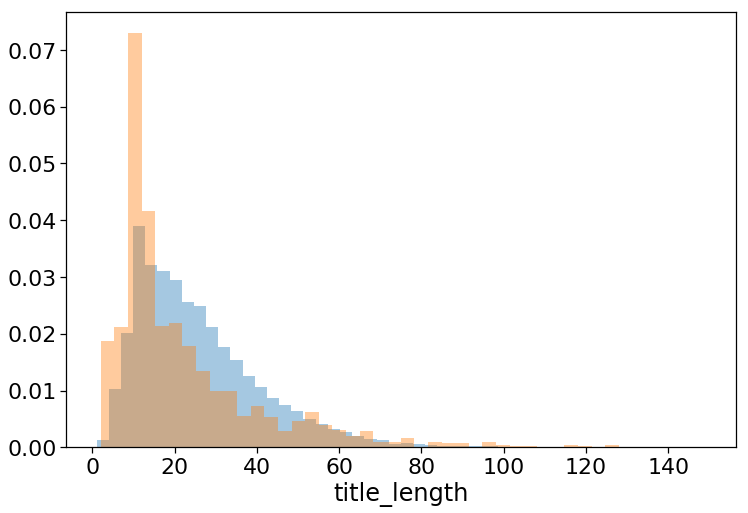

In [103]:
# Plot histograms of title lengths for all reviews. norm_hist normalizes the histogram.
reviews_with_lengths.plot(x="title_length", kind="hist", norm_hist=True)
reviews_with_lengths.filter("is_fake_candidate").plot(x="title_length", kind="hist", norm_hist=True)

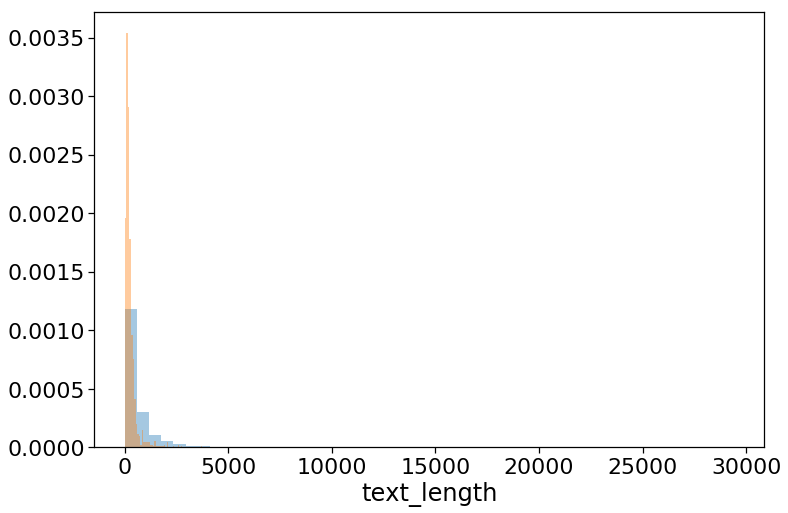

In [104]:
# Plot histograms of body lengths for all reviews. norm_hist normalizes the histogram.
reviews_with_lengths.plot(x="text_length", kind="hist", norm_hist=True)
reviews_with_lengths.filter("is_fake_candidate").plot(x="text_length", kind="hist", norm_hist=True)

The plot above is not super-helpful because there's a very wide variance in the lengths of review bodies. _Logarithmic scales_ to the rescue!

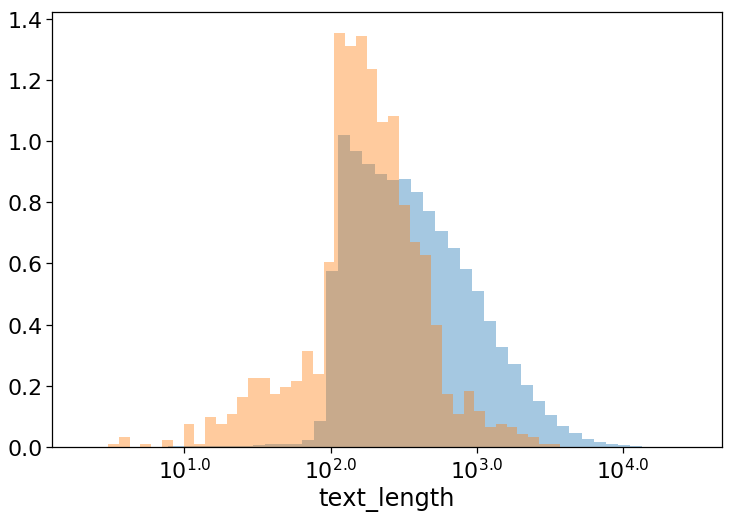

In [129]:
%run init.py

# Plotting on a logarithmic scale makes it easier to look at the tails of the distribution.
# Plot histograms of body lengths for all reviews. norm_hist normalizes the histogram.
reviews_with_lengths.plot(x="text_length", kind="hist", norm_hist=True, logx=True)
reviews_with_lengths.filter("is_fake_candidate").plot(x="text_length", kind="hist", norm_hist=True, logx=True)

When we plot using a logarithmic axis, it becomes a lot clearer that there's a significant tail of reviews with very *short* (<100 characters) body. For reference, this box has exactly 200 characters.

# Free-form task: for what product are reviews most "inflated"?

Each product is identified by `asin`. Find the product that might have the most inflated reviews based on your hunches on what fake reviews look like.

Possible hunches:
- One of the heuristics we already computed
- Average review lengths
- Number of reviews we marked as "suspicious"
- Review posting rate for an item (i.e. number of reviews posted in a time interval)
- Contain the sentence "honest review", "sponsored", or whatever you think indicates a potential fake (use the SQL expression `like` inside `expr()`, example:

```
df.withColumn("contains_sponsored", expr("reviewText like '%sponsored%'")) 
```
- ...

Once you have set up your query:
1. Identify one or two candidate products by `asin`
2. Search for the `asin` on Amazon.com (just enter it in the search bar)
3. copy the Amazon URL into [https://www.fakespot.com/](https://www.fakespot.com/) to check what their model thinks about the reviews.

In [135]:
# TODO: Do the exercise. The example below is for illustrative purposes.

# A worked out example:
# 
fakes = reviews_with_lengths.groupBy("asin").agg(F.count("is_fake_candidate").alias("count_fakes"))

# Show in descending count of fakes
display(fakes.orderBy(F.desc("count_fakes")))

,asin,count_fakes
0,B007WTAJTO,4915
1,B003ES5ZUU,4143
2,B00DR0PDNE,3798
3,B0019EHU8G,3435
4,B002WE6D44,2813
5,B003ELYQGG,2652
6,B0002L5R78,2599
7,B009SYZ8OC,2542
8,B00BGGDVOO,2104
9,B002V88HFE,2082


# Where does a Data Scientist go next?